# Deep Learning
# 深度学习

一、深度学习核心思路：  
表示学习和特征学习，深度学习一般自动学习有用的特征  
<img src="deep_learning_core.png" width="400">   

二、万能逼近原理:   
当隐含层节点数目足够多时，具有一个隐含层的神经网络可以以任意精度逼近 任意具有有限间断点的函数。  
深度学习通过一种深层网络结构，实现复杂函数逼近。  
网络层数越多，需要的隐含节点数目指数减小。    
<img src="万能逼近.png" width="600">  

三、端到端学习:  
从原始输入直接学习到目标的函数，中间的函数和参数都是可学习的。  
不需要做其他额外处理，从原始数据输入到任务结果输出，整个训练和预测过程，都是在模型里完成的  
<img src="端到端.png" width="600">  

### 导入需要的包

In [1]:
# 导入 NumPy 和 Pandas
import numpy as np           # 用于数值计算，特别是数组操作
import pandas as pd          # 用于数据读取、处理和分析（表格数据）

# 从 matplotlib.pyplot 中导入 subplots，用于绘图和可视化
from matplotlib.pyplot import subplots

# 从 sklearn.linear_model 模块中导入线性回归、逻辑回归和 Lasso 回归模型
from sklearn.linear_model import (
     LinearRegression,       # 普通最小二乘线性回归
     LogisticRegression,     # 用于分类的逻辑回归
     Lasso                   # 加入 L1 正则化的线性回归（用于特征选择）
)

# 导入标准化工具 StandardScaler：将特征缩放为均值为 0，标准差为 1
from sklearn.preprocessing import StandardScaler

# 导入 K 折交叉验证工具
from sklearn.model_selection import KFold

# 导入 Pipeline，用于将多个处理步骤（如标准化 + 模型）封装为一个整体
from sklearn.pipeline import Pipeline

# 从 ISLP 库中导入数据加载函数（ISLP 是《An Introduction to Statistical Learning》教材配套库）
from ISLP import load_data

# 从 ISLP.models 模块中导入 ModelSpec，用于指定模型公式（R 语言风格）
from ISLP.models import ModelSpec as MS

# 导入训练集/测试集划分工具和超参数搜索工具 GridSearchCV
from sklearn.model_selection import (
     train_test_split,       # 将数据划分为训练集和测试集
     GridSearchCV            # 网格搜索交叉验证，用于模型调参
)


In [2]:
# 导入 PyTorch 主库，包含张量操作和自动求导等功能
import torch

# 从 torch.nn 模块中导入神经网络相关的功能，例如层结构、激活函数、损失函数等
from torch import nn

# 从优化器模块中导入 RMSprop 优化算法，用于更新模型参数
from torch.optim import RMSprop

# 从数据工具模块中导入 TensorDataset 和 DataLoader
# TensorDataset 用于将特征和标签打包成一个数据集对象
# DataLoader 用于按批次加载数据，支持打乱顺序、并行加载等功能
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# 从 torchmetrics 库中导入评估指标：
from torchmetrics import (
    MeanAbsoluteError,  # 平均绝对误差（MAE），衡量预测值与真实值之间的绝对差异
    R2Score              # 决定系数 R²，用于衡量模型对数据的拟合程度
)

# 从 torchinfo 库中导入 summary 函数：
from torchinfo import summary  # 用于打印模型结构摘要（类似 Keras 的 model.summary()）


In [4]:
# 从 PyTorch Lightning 中导入 Trainer，这是训练模型的核心控制器
from pytorch_lightning import Trainer

# 从 PyTorch Lightning 的日志模块中导入 CSVLogger，用于将训练过程中的指标记录到 CSV 文件中
from pytorch_lightning.loggers import CSVLogger



In [5]:
# 从 PyTorch Lightning 中导入设置随机种子的工具函数
from pytorch_lightning import seed_everything

# 设置所有相关库的随机种子为 0，以确保实验具有可重复性
# workers=True 还会确保多线程的数据加载也是可控的（对 DataLoader 的 num_workers 生效）
seed_everything(0, workers=True)

# 让 PyTorch 使用确定性算法（即每次运行都得到完全相同的结果）
# warn_only=True 表示如果某些操作无法确定性执行，仅发出警告而不中断程序
torch.use_deterministic_algorithms(True, warn_only=True)


Seed set to 0


我们将使用torchvision附带的几个数据集作为示例：用于图像分类的预训练网络，以及用于预处理的一些变换。

In [6]:
# 从 torchvision.io 模块中导入 read_image，用于读取图像文件为张量格式
from torchvision.io import read_image

# 导入两个常用的数据集：
from torchvision.datasets import MNIST, CIFAR100
# MNIST 是手写数字识别数据集（灰度图像 28x28）
# CIFAR100 是彩色图像分类数据集（共 100 类，图像大小为 32x32）

# 导入 ResNet50 模型和其预训练权重
from torchvision.models import (
    resnet50,              # ResNet-50 模型结构，适合图像分类任务
    ResNet50_Weights       # 包含预训练模型的权重配置（如 ImageNet 上训练好的）
)

# 导入图像变换操作，这些常用于数据预处理或增强
from torchvision.transforms import (
    Resize,                # 缩放图像到指定尺寸
    Normalize,             # 对图像做标准化（通常用于预训练模型）
    CenterCrop,            # 中心裁剪图像
    ToTensor               # 将 PIL 图像或 numpy 数组转为 PyTorch 的张量（并自动归一化到 [0,1]）
)


In [7]:
# 从 ISLP.torch 模块中导入一些 PyTorch 相关的工具和类：
from ISLP.torch import (
    SimpleDataModule,      # 用于加载和处理数据的简单模块，通常包含数据集加载、预处理等功能
    SimpleModule,          # 用于构建简单神经网络模型的类，封装了常见的 PyTorch 模型训练过程
    ErrorTracker,          # 用于跟踪训练过程中的误差和其他指标
    rec_num_workers        # 推荐的 DataLoader 中的 num_workers 设置，帮助加速数据加载
)

In [8]:
# 从 ISLP.torch.imdb 模块中导入四个函数，用于加载 IMDB 数据集相关的数据
from ISLP.torch.imdb import (
    load_lookup,           # 加载词汇表（词与索引的映射关系）
    load_tensor,           # 加载并转换数据为 PyTorch 张量（通常是文本数据）
    load_sparse,           # 加载稀疏数据（例如稀疏矩阵）
    load_sequential        # 加载序列数据（例如逐字或逐词处理的文本数据）
)

In [9]:
# 从 glob 模块导入 glob 函数，用于查找匹配特定规则的文件路径
from glob import glob

# 导入 json 模块，用于处理 JSON 格式的数据，用于查找类以识别ResNet50示例中图片的标签。
import json

## Single Layer Network on Hitters Data
## 在 Hitters 数据集上应用单层神经网络进行回归任务
输入层 + 一个隐藏层+ 输出层

### 一、线性回归模型

- 模型参数：$\hat{w}_1$ 和 $\hat{w}_0$  
- 模型预测值：$\hat{y}_i$  
- 残差定义：$\varepsilon_i = y_i - \hat{y}_i$  
- 若输入数据维度从 1 维上升到 $d$ 维，多元线性回归形式为：

$$
\hat{y}_i = \hat{w}_0 + \hat{w}_1 x_{i1} + \hat{w}_2 x_{i2} + \cdots + \hat{w}_d x_{id}
$$

向量形式为：

$$
\hat{y}_i = \mathbf{x}_i^\top \hat{\mathbf{w}} = \sum_{j=1}^{d} \hat{w}_j x_{ij}
$$

多元线性回归模型也可以表示为如下的图结构：

- 每一个圆形代表一个神经元（即输入变量的一维）  
- 该图结构可视为一个没有隐藏层的神经网络（只有输入层和输出层）  

<img src="多元回归.png" width="400">

---

### 二、逻辑回归模型

- 属于线性分类模型  
- 使用 Sigmoid 函数将线性回归的输出转化为概率值  
- 可视为一种单层神经网络，激活函数为 Sigmoid  

<img src="逻辑回归.png" width="500">

> 💡 逻辑回归与线性回归模型都可以作为神经网络的基础“组件”

---

### 三、神经网络

神经网络是 20 世纪 80 年代以来人工智能领域兴起的研究热点。其广泛应用包括：

- **欺诈检测**：自动检测信用卡欺诈交易  
- **信用评级**：基于用户或企业经济信息进行风险评估  
- **语音识别**：将语音数据转换为自然语言文本  
- **医疗诊断**：根据医学指标判断疾病可能性  

人工神经网络是对人脑神经元网络的抽象，其基本构成包括：

- 节点（神经元）和连接关系  
- **激活函数**：控制神经元输出  
- **权重**：表示信号强度，决定网络的“记忆能力”  

<img src="神经元.png" width="600">

在 M-P 神经元模型中：

- 接收其他神经元的输入信号  
- 信号通过加权连接传递  
- 输入总信号与阈值比较，经过激活函数得到输出  

---

### 四、感知机模型（Perceptron）

感知机是由两层神经元组成的简单神经网络模型：

- **输入层**：接收外界输入  
- **输出层**：由 M-P 神经元构成，带激活函数  
- 仅输出层使用激活函数，输入层为“直通”连接
- 下图为输入层到输出层的感知机模型

<img src="Perceptron.png" width="300">

---
### 五、多层感知机（MLP, Multi-Layer Perceptron）

MLP 是感知机的拓展，结构中引入隐藏层：

- 可以有多个隐藏层，支持复杂非线性函数建模  
- 每一层神经元均可使用激活函数  
- 在图像分类、文本处理、推荐系统等任务中广泛应用
- 下图感知机隐藏层为一层

<img src="MLP.png" width="500">

- **前馈神经网络**：信息从输入层到输出层是单向流动的，没有环路。
  
- **监督学习模型**：多层感知机是一个监督学习模型，通常作为 **函数逼近器** 使用。
  
- **函数逼近**：通过在训练集中寻找最优参数 $\theta$，从而得到函数 $f(x, \theta)$ 的最优近似。

- **多层网络结构**：将含有一层隐含层的感知机网络推广到多层结构，数学表达式为：

  $$
  f(x) = f_n(f_{n-1}(\dots f_1(x)))
  $$

  其中，$f_1(x)$ 是输入层到第一个隐藏层的映射，$f_2(x)$ 是第一个隐藏层到第二个隐藏层的映射，依此类推，最终通过 $f_n(x)$ 生成输出层的预测值。

通过这种多层结构，MLP 可以通过组合多个非线性变换来逼近复杂的函数映射，因此它非常适用于分类和回归任务。
<img src="多层感知机.png" width="500">


激活函数（Activation Functions）

为什么需要激活函数？

- 如果没有非线性因素（即不使用激活函数），**无论神经网络有多少层，其输出都是输入的线性组合**，无法表示复杂的非线性关系。
- 激活函数的作用是在**线性模型的基础上引入非线性因素**，从而让神经网络具备更强的表达能力。

---

常见激活函数

 1. 线性函数（Linear）
$$
f(x) = x
$$

- 特点：恒等映射，不引入非线性
- 缺点：无法建模非线性关系，**不常用于隐藏层**

---

 2. 阈值激活函数（Threshold / Step）
$$
f(x) = \begin{cases} 
1 & x > 0 \\
0 & x \leq 0 
\end{cases}
$$

- 模拟生物神经元“有/无”信号传递
- 缺点：不可导，**不适合梯度下降法**

---

 3. Sigmoid 函数
$$
f(x) = \frac{1}{1 + e^{-x}}
$$

- 输出范围：$(0, 1)$
- 应用：适合用于二分类任务输出层
- 缺点：
  - 梯度消失（在极端值处导数接近 0）
  - 输出非零均值，导致训练不稳定

---

 4. Tanh 函数（双曲正切）
$$
f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

- 输出范围：$(-1, 1)$
- 比 Sigmoid 更强（零均值，有助于优化）
- 同样存在梯度消失问题

---

 5. ReLU 函数（Rectified Linear Unit）
$$
f(x) = \begin{cases}
x & x > 0 \\
0 & x \leq 0
\end{cases}
$$

- 应用广泛，是大多数深度前馈神经网络的默认激活函数
- 优点：
  - 计算简单，快速训练
  - 减少梯度消失问题
  - 提供稀疏性（部分神经元输出为 0）
- 缺点：
  - 当输入为负数时，梯度为 0，可能导致“神经元死亡”

---

 6. Softmax 函数
用于多分类任务的输出层：

$$
f_i(x) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

- 输出为一个概率分布，所有输出之和为 1
- 常用于多类分类问题的最后一层

---

损失函数

损失函数是神经网络优化的目标函数，它反映了神经网络对数据集的拟合程度。

- **拟合程度**：当神经网络对数据集拟合得越差时，损失函数的值会越大。
- **梯度更新**：损失函数值较大时，梯度也会比较大，从而能够更快速地更新模型的参数（即神经网络的权重）。

神经网络损失函数的特征：

- **非负性**：损失函数的值总是非负的。它的值越小，表示模型对数据集的拟合程度越好。
- **收敛性**：当预测值 $ \hat{y} $ 与真实值 $ y $ 接近时，损失函数值趋近于零。

数学表达式：

神经网络的目标是最小化损失函数 $ \text{loss}(y, \hat{y}) $：

$$
\min \text{loss}(y, \hat{y})
$$

其中，$ y $ 是真实值，$ \hat{y} $ 是预测值，损失函数根据具体任务（如回归、分类）选择不同的计算方式。

损失函数：均方误差（MSE）与交叉熵（Cross-Entropy）

 1. **均方误差（MSE）**

均方误差（Mean Squared Error, MSE）是回归问题中最常用的损失函数之一，它测量的是预测值与真实值之间的平均平方差。

- **公式**：

  对于一组预测值 $ \hat{y}_i $ 和真实值 $ y_i $，均方误差的公式为：

  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$

  其中，$ n $ 是样本数，$ y_i $ 是真实值，$ \hat{y}_i $ 是模型的预测值。

- **特性**：
  - MSE 越小，模型的预测结果与实际结果越接近。
  - 它对异常值敏感，因为平方差放大了较大的误差。

 2. **交叉熵（Cross-Entropy）**

交叉熵（Cross-Entropy）通常用于分类问题，尤其是二分类和多分类问题。它用来衡量两个概率分布之间的差异，即真实标签的概率分布与模型预测的概率分布之间的差异。

- **二分类交叉熵**：

  对于二分类问题，交叉熵损失函数的公式为：

  $$
  \text{Cross-Entropy} = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
  $$

  其中，$ n $ 是样本数，$ y_i $ 是真实标签（0 或 1），$ \hat{y}_i $ 是模型的预测概率。

- **多分类交叉熵**：

  对于多分类问题，交叉熵的公式为：

  $$
  \text{Cross-Entropy} = - \frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{ic} \log(\hat{y}_{ic})
  $$

  其中，$ C $ 是类别数，$ y_{ic} $ 是样本 $ i $ 的真实类别标签（1 表示属于类别 $ c $，0 表示不属于），$ \hat{y}_{ic} $ 是模型预测样本 $ i $ 属于类别 $ c $ 的概率。

- **特性**：
  - 交叉熵越小，表示模型预测的类别概率分布越接近真实标签的分布。
  - 对于二分类问题，交叉熵会根据模型预测的概率调整损失值，帮助模型更快地收敛。


In [10]:
# 加载 Hitters 数据集，并去除含有缺失值的行
Hitters = load_data('Hitters').dropna()

# 获取数据集中的样本数（即行数）
n = Hitters.shape[0]

In [11]:
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


 要比较 线性回归模型（最小二乘法）、Lasso 回归模型 和 神经网络模型 的表现，我们将使用 平均绝对误差（Mean Absolute Error, MAE） 作为性能指标，并使用验证集进行评估。
\begin{equation*}
\begin{split}
\mbox{MAE}(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^n |y_i-\hat{y}_i|.
\end{split}
\end{equation*}
设置模型矩阵：将数据集的特征（ Hitters 数据集中的各种属性）作为模型矩阵。
设置响应变量：将目标变量（ Salary，即球员年薪）提取为响应变量。

In [12]:
#  从 Hitters 数据集的列中移除 Salary 列，不包括截距项，
#  将数据集传递给模型规范 MS，并执行数据转换，返回一个已处理的特征矩阵 X
model = MS(Hitters.columns.drop('Salary'), intercept=False)

# 使用 fit_transform 处理数据，得到特征矩阵 X
X = model.fit_transform(Hitters).to_numpy()

# 提取目标变量（薪水）Y
Y = Hitters['Salary'].to_numpy()

# 显示特征矩阵 X 的前5行
print("特征矩阵 X:")
print(X[:5])  # 显示前5个样本的特征

# 显示目标变量 Y (薪水) 的前5个值
print("\n目标变量 Y (薪水):")
print(Y[:5])  # 显示前5个薪水值

特征矩阵 X:
[[3.150e+02 8.100e+01 7.000e+00 2.400e+01 3.800e+01 3.900e+01 1.400e+01
  3.449e+03 8.350e+02 6.900e+01 3.210e+02 4.140e+02 3.750e+02 1.000e+00
  1.000e+00 6.320e+02 4.300e+01 1.000e+01 1.000e+00]
 [4.790e+02 1.300e+02 1.800e+01 6.600e+01 7.200e+01 7.600e+01 3.000e+00
  1.624e+03 4.570e+02 6.300e+01 2.240e+02 2.660e+02 2.630e+02 0.000e+00
  1.000e+00 8.800e+02 8.200e+01 1.400e+01 0.000e+00]
 [4.960e+02 1.410e+02 2.000e+01 6.500e+01 7.800e+01 3.700e+01 1.100e+01
  5.628e+03 1.575e+03 2.250e+02 8.280e+02 8.380e+02 3.540e+02 1.000e+00
  0.000e+00 2.000e+02 1.100e+01 3.000e+00 1.000e+00]
 [3.210e+02 8.700e+01 1.000e+01 3.900e+01 4.200e+01 3.000e+01 2.000e+00
  3.960e+02 1.010e+02 1.200e+01 4.800e+01 4.600e+01 3.300e+01 1.000e+00
  0.000e+00 8.050e+02 4.000e+01 4.000e+00 1.000e+00]
 [5.940e+02 1.690e+02 4.000e+00 7.400e+01 5.100e+01 3.500e+01 1.100e+01
  4.408e+03 1.133e+03 1.900e+01 5.010e+02 3.360e+02 1.940e+02 0.000e+00
  1.000e+00 2.820e+02 4.210e+02 2.500e+01 0.000e+00]]

目标变量 

上面提到的 to_numpy() 方法将 Pandas 的数据框（DataFrame）或序列（Series）转换为 NumPy 数组。
我们这样做是因为在拟合 Lasso 模型时需要使用 scikit-learn，而它要求输入数据是 NumPy 数组格式。
我们还使用了 scikit-learn 中的线性回归方法，而不是第 3 章中 statsmodels 的方法，以便于进行比较。

我们将数据集分成训练集和测试集，并固定使用 sklearn 中的随机种子（random_state），以确保每次分割数据时的结果是相同的。

In [13]:
# 特征矩阵 X 和目标变量 Y 分割为训练集和测试集
(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,  # 数据集的 1/3 用作测试集，剩下的 2/3 用作训练集
                            random_state=1)

# 输出训练集和测试集的形状
print("训练集特征 X_train 形状:", X_train.shape)
print("测试集特征 X_test 形状:", X_test.shape)
print("训练集目标 Y_train 形状:", Y_train.shape)
print("测试集目标 Y_test 形状:", Y_test.shape)


训练集特征 X_train 形状: (175, 19)
测试集特征 X_test 形状: (88, 19)
训练集目标 Y_train 形状: (175,)
测试集目标 Y_test 形状: (88,)


### Linear Models
我们拟合线性模型并直接评估测试误差

In [14]:
hit_lm = LinearRegression().fit(X_train, Y_train) #使用训练集 X_train 和 Y_train 拟合线性回归模型
Yhat_test = hit_lm.predict(X_test) #训练好的模型对测试集 X_test 进行预测，得到预测值 Yhat_test
np.abs(Yhat_test - Y_test).mean() #计算 平均绝对误差（MAE），即预测值与实际值之间的绝对差的平均值

259.71528833146294

接下来，我们使用 sklearn 拟合 Lasso 模型。
我们将使用 平均绝对误差（MAE） 来选择和评估模型，而不是使用均方误差（MSE）。  
在这里，我们将创建一个交叉验证网格，并直接执行交叉验证。  
我们使用一个包含两个步骤：首先使用 StandardScaler() 转换标准化特征，然后拟合 Lasso 模型。
- 构建一个“标准化 + Lasso”的流水线模型，
- 用 交叉验证 + 网格搜索 自动选出最佳参数，
- 并用 MAE 来评估模型效果。

In [15]:
# 在一组不同的正则化强度（λ）下训练模型 → 评估性能 → 选择最优的 λ。

scaler = StandardScaler(with_mean=True, with_std=True) 
# 特征标准化，将每个特征的均值设为 0，标准差设为 1

lasso = Lasso(warm_start=True, max_iter=30000) 
# 启用 warm start 功能，允许你在多次调用 .fit() 方法时复用上一次训练的结果，最大迭代次数为 30,000

standard_lasso = Pipeline(steps=[('scaler', scaler), #首先使用 StandardScaler 对数据进行标准化处理
                                 ('lasso', lasso)]) #标准化后的数据传递给 Lasso 回归模型进行训练和预测

我们需要为 λ 创建一个值的网格。  
通常的做法是选择 100 个 λ 值，这些值在对数尺度上均匀分布，从 `lam_max` 到 `0.01 * lam_max`。  
其中，`lam_max` 是使所有回归系数为零时的最小 λ 值。  
该值等于预测变量与中心化后的响应变量之间的最大绝对内积。  
通过选择这样一个 λ 值的网格，我们能够控制模型的正则化强度，并帮助选择最合适的 λ 来防止过拟合。


In [16]:
# 对训练集特征进行标准化，确保每个特征的均值为0，标准差为1
X_s = scaler.fit_transform(X_train)

# 获取样本数 n，即标准化后特征矩阵的行数
n = X_s.shape[0]

# 计算 lam_max，这是使所有回归系数为零的最小 lambda 值
# 首先，中心化 Y_train（即减去其均值），然后计算标准化特征与中心化响应的内积
# 获取该内积的最大绝对值，并除以样本数 n 得到 lam_max
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n

# 创建 λ 的网格，生成100个 λ 值，这些值在对数尺度上均匀分布
# λ 的范围从 lam_max 到 0.01*lam_max
# np.linspace 生成从 0 到 np.log(0.01) 的100个对数值，然后通过 np.exp 进行指数变换得到实际的 λ 值
# 最后，乘以 lam_max 来调整 λ 的范围
param_grid = {'lasso__alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}


我们必须先对数据进行转换（标准化），因为变量的尺度会影响 λ 的选择。现在，我们使用这一系列 λ 值进行交叉验证

In [17]:
# 定义 10 折交叉验证，数据集分为 10 份，每次用 9 份数据训练，剩下 1 份作为验证集。
cv = KFold(10, 
           shuffle=True,  # 打乱数据，避免数据顺序影响交叉验证结果
           random_state=1)  # 设置随机种子，保证每次划分的折叠相同

# 使用 GridSearchCV 进行网格搜索，选择最佳的 lambda 
# `standard_lasso` 是包含标准化步骤和 Lasso 回归的管道
# `param_grid` 是我们之前创建的包含不同 lambda 值的参数网格
# `cv=cv` 表示使用 10 折交叉验证
# `scoring='neg_mean_absolute_error'` 表示使用负的平均绝对误差（MAE）来选择最优模型
grid = GridSearchCV(standard_lasso,
                    param_grid,    # 参数网格
                    cv=cv,         # 交叉验证
                    scoring='neg_mean_absolute_error')  # 使用负 MAE 作为评估标准

# 执行网格搜索，找到最佳的 lambda 值
grid.fit(X_train, Y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso',
                                        Lasso(max_iter=30000,
                                              warm_start=True))]),
             param_grid={'lasso__alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.262...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

我们提取具有最佳交叉验证平均绝对误差（MAE）的 Lasso 模型（lamada=14.97），并在 X_test 和 Y_test 上评估其性能，这些测试数据没有参与交叉验证过程。

In [18]:
# 提取最佳的 Lasso 模型
trained_lasso = grid.best_estimator_

# 使用最佳模型对测试集进行预测
Yhat_test = trained_lasso.predict(X_test)

# 计算测试集的平均绝对误差（MAE）
mae_test = np.fabs(Yhat_test - Y_test).mean()

# 打印测试集的 MAE
print("测试集的平均绝对误差 (MAE):", mae_test)

测试集的平均绝对误差 (MAE): 235.67548374780287


这与我们通过最小二乘拟合线性模型时得到的结果(259)类似。然而，对于不同的训练集/测试集划分，这些结果可能会有很大变化；

### Specifying a Network: Classes and Inheritance
在 PyTorch 中，我们通常通过 **继承** 来定义神经网络结构。以下是具体步骤：

---
#### 1. **继承 `nn.Module`**

- 我们创建一个新的类，继承 `nn.Module` 类，以便利用 PyTorch 的模型管理、参数优化、反向传播等功能。

---

#### 2. **定义网络结构（`__init__` 方法）**

- 在新类中，我们通常会通过 `__init__` 方法来定义网络的各个层，例如卷积层、线性层、激活函数等。
- `__init__` 方法用于初始化网络的各个层和参数。

---

#### 3. **实现前向传播（`forward` 方法）**

- 通过重写 `forward` 方法，我们定义数据如何在各个层之间流动。
- PyTorch 会自动处理梯度计算和优化过程，无需手动实现反向传播。

---


In [19]:
class HittersModel(nn.Module):
    # 定义一个用于 Hitters 数据的神经网络模型，继承自 PyTorch 的 nn.Module 基类

    def __init__(self, input_size):
        # 构造函数，input_size 是输入特征的维度（即 X 的列数）
        super(HittersModel, self).__init__()

        # 定义一个展平层（多维数组转变为一维向量）
        self.flatten = nn.Flatten()

        # 定义一个顺序网络：	Linear + ReLU + Dropout 构成一个隐藏层模块
        # - 第一层：全连接层，将输入映射到 50 个神经元
        # - 第二层：ReLU 激活函数
        # - 第三层：Dropout 层，防止过拟合，丢弃 40% 的神经元
        # - 第四层：全连接层，将 50 个输出映射到 1 个输出值（回归任务）
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        # 前向传播函数，定义数据如何流经网络
        x = self.flatten(x)  # 展平输入（主要用于兼容某些输入格式）
        return torch.flatten(self.sequential(x))  # 输出展平为一维张量（与目标 Y 对齐）


In [20]:
# 创建一个 HittersModel 类的实例，输入特征数量为 X 的列数（即每个样本的特征维度）
hit_model = HittersModel(X.shape[1])


对象 self.sequential 是由四个映射（层）组成的一个复合结构：

第一层将 Hitters 数据集中的 19 个特征映射到 50 维，
这会引入 $50 \times 19 + 50$ 个可训练参数，分别对应于：

50 个输出神经元 × 19 个输入特征（权重）

50 个偏置项（bias，即截距）

然后，输出被送入一个 ReLU 激活层，用于引入非线性。

接着是一个 Dropout 层，随机丢弃 40% 的神经元，用于减少过拟合。

最后是一个 线性输出层，将 50 维的向量映射为 1 个输出值（即预测的工资），
这会再引入 50 个权重和 1 个偏置参数。

因此，模型中可训练参数的总数为：

50×19+50+50+1=1051

torchinfo 包提供了一个 summary() 函数，可以整洁地汇总神经网络结构的信息。

我们可以指定输入张量的尺寸，然后 summary() 会展示每一层的张量在网络中传播时的尺寸变化，以及每一层的参数数量。

这有助于我们更好地理解模型的结构和复杂度

In [21]:
# 使用 summary 函数展示模型的结构信息
# 其中 input_size=X_train.shape 指定了输入张量的大小
# col_names 参数指定了输出中列的名称
# 包括 'input_size'（输入大小），'output_size'（输出大小），'num_params'（参数数量）
summary(hit_model, 
        input_size=X_train.shape,  # 指定输入的大小，这里是训练数据的形状
        col_names=['input_size',  # 输出中列名为：输入大小
                   'output_size',  # 输出大小
                   'num_params'])  # 参数数量

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

接下来，我们需要将训练数据转换为 torch 可以访问的格式。
torch 中的基本数据类型是 tensor（张量），它与之前章节中的 ndarray（N维数组） 非常相似。

此外，需要注意的是，torch 通常使用 32 位单精度浮点数（float32），而不是 64 位双精度浮点数（float64）。
因此，在创建张量之前，我们需要将数据转换为 np.float32 类型。

然后，我们将 $X$ 和 $Y$ 转换为 Dataset，这是 torch 可以识别的数据集格式，
使用 TensorDataset() 来构造。

In [22]:
# 将训练数据 X_train 转换为 torch 的张量，并将数据类型设置为 float32（单精度浮点数）
X_train_t = torch.tensor(X_train.astype(np.float32))

# 将目标数据 Y_train 转换为 torch 的张量，并将数据类型设置为 float32（单精度浮点数）
Y_train_t = torch.tensor(Y_train.astype(np.float32))

# 创建一个 TensorDataset，将输入特征张量 X_train_t 和目标张量 Y_train_t 封装在一起
hit_train = TensorDataset(X_train_t, Y_train_t)


In [23]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)


最终，这个数据集被传递给 DataLoader()，后者将数据传入我们的神经网络。虽然这看起来可能会增加一些开销，但这种结构对于更复杂的任务是非常有用的，尤其是在数据可能分布在不同机器上，或者数据需要传递到 GPU 上的情况下。

在 ISLP 中，我们提供了一个辅助函数 SimpleDataModule() 来简化这个任务，便于标准使用。
它的一个参数是 num_workers，表示我们将使用多少个进程来加载数据。对于像 Hitters 这样的较小数据集，这个参数的影响不大，但对于下面的 MNIST 和 CIFAR100 示例，它会有显著的性能提升。

torch 包会检查当前运行的进程并确定最大可用的工作进程数。
（这取决于计算硬件和可用的核心数量）。
我们还提供了一个函数 rec_num_workers() 来计算这个值，以帮助我们确定合理的工作进程数（在这里最大值是 16）。

In [24]:
# 调用 rec_num_workers() 函数来计算合理的最大工作进程数，并将结果赋值给 max_num_workers
max_num_workers = rec_num_workers()


在 pytorch_lightning 中，一般的训练设置包括训练、验证和测试数据。这些数据分别由不同的数据加载器（data loaders）表示。每个训练周期（epoch）中，我们会执行以下步骤：

训练步骤：用于训练模型并学习参数。

验证步骤：用于跟踪误差并监控模型在验证集上的表现。

测试数据通常在训练结束时用来评估模型。

在本例中，由于我们只进行了训练集和测试集的划分，因此我们将使用测试数据作为验证数据，并通过 validation=hit_test 来指定。
validation 参数可以是以下几种形式：

浮动数值（float）：介于 0 和 1 之间，表示训练数据中用于验证的比例。

整数（integer）：表示用于验证的训练数据的样本数量。

Dataset 对象：直接作为验证数据传递给数据加载器。

In [25]:
# 使用 SimpleDataModule 创建数据模块
# 传入训练数据 hit_train、测试数据 hit_test，并设置以下参数：
# - batch_size=32：每个批次包含32个样本
# - num_workers=min(4, max_num_workers)：数据加载的工作进程数，取 4 和 max_num_workers 中的较小值
# - validation=hit_test：将测试数据作为验证数据
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)


接下来，我们需要提供一个 pytorch_lightning 模块，用于控制训练过程中的各个步骤。
我们为 SimpleModule() 提供了方法，这些方法在每个训练周期（epoch）结束时，简单地记录损失函数的值和任何附加的度量指标（metrics）。
这些操作是通过 SimpleModule.[training/test/validation]_step() 方法来控制的

In [26]:
# 使用 SimpleModule 创建一个回归模型模块
# 传入已经定义的 hit_model 作为模型，并设置评估指标为均值绝对误差 (Mean Absolute Error, MAE)
hit_module = SimpleModule.regression(hit_model,
                           metrics={'mae': MeanAbsoluteError()})


通过使用 SimpleModule.regression() 方法，我们表明将使用 平方误差损失（squared-error loss）。
我们还要求跟踪 均值绝对误差（MAE） 作为附加的度量指标，并将其记录在日志中。

我们通过 CSVLogger() 来记录结果，该方法将在 logs/hitters 目录下存储结果的 CSV 文件。训练完成后，我们可以加载这个 CSV 文件，将其转换为 pd.DataFrame()，然后在后续步骤中对结果进行可视化。
pytorch_lightning 提供了多种日志记录方式

In [27]:
from pytorch_lightning.loggers import CSVLogger

# 使用 CSVLogger 记录训练过程的日志
# 日志将存储在 'logs' 目录下，并命名为 'hitters' 文件夹
hit_logger = CSVLogger('logs', name='hitters')


最后，我们准备好训练模型并记录结果。我们使用 pytorch_lightning 中的 Trainer() 对象来执行这项工作。
参数 datamodule=hit_dm 告诉训练器如何生成训练、验证和测试日志，而第一个参数 hit_module 则指定了网络架构，并包含了训练、验证和测试步骤。

callbacks 参数允许在训练过程中多个阶段执行不同的任务。在这里，我们使用 ErrorTracker() 回调，它会在训练过程中帮助我们计算验证误差，并最终计算测试误差。

我们将训练模型 50 个周期（epochs）

一个训练周期（epoch）指的是模型完成对整个训练数据集的遍历和参数更新。

In [29]:
from pytorch_lightning import Trainer
# 创建一个 Trainer 对象来管理模型训练过程
hit_trainer = Trainer(
    deterministic=True,             # 设置确定性结果（确保每次运行结果一致，便于调试）
    max_epochs=50,                  # 设置训练周期数为 50
    log_every_n_steps=5,            # 每训练 5 个步骤记录一次日志
    logger=hit_logger,              # 使用之前定义的 CSVLogger 对象记录日志
    callbacks=[ErrorTracker()],      # 使用 ErrorTracker 回调函数跟踪验证和测试误差
    enable_progress_bar=False
)

# 开始训练模型，使用定义好的模型结构和数据模块
hit_trainer.fit(hit_module, datamodule=hit_dm)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.


在每一步随机梯度下降（SGD）中，算法会随机选择 32 个训练样本来计算梯度。
一个 epoch 的定义是：完成对全部 n 个训练样本的一次处理所需的 SGD 步数。
由于我们的训练集共有 n=175 个样本，并且我们在构建 hit_dm 时设定了 batch_size=32，
因此一个 epoch 约等于：
175/32≈5.5
也就是说，一个 epoch 包含大约 5.5 次 SGD 更新步骤。
（梯度下降：选择能使得损失函数下降最快的设置迭代更新）

In [30]:
# 使用训练好的模型在测试数据集上评估性能
# hit_trainer 是训练器对象，控制训练与测试流程
# hit_module 是定义好的神经网络模型
# datamodule=hit_dm 指定测试数据集来源（hit_dm 中已包含 test 集）
hit_trainer.test(hit_module, datamodule=hit_dm)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      103304.8671875       │
│         test_mae          │    224.26962280273438     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 103304.8671875, 'test_mae': 224.26962280273438}]

本次拟合的结果已被记录到一个 CSV 文件中。我们可以通过 logger 的 experiment.metrics_file_path 属性，找到与此次运行相关的结果文件。

请注意：每次训练模型时，logger 都会将结果输出到我们指定的目录 logs/hitters 的一个新的子目录中。

接下来，我们将绘制平均绝对误差（MAE）随训练轮数（epoch）变化的图像。
首先，我们需要读取记录下来的训练摘要数据。

In [31]:
# 读取训练过程中记录的结果数据
# 使用 pandas 的 read_csv 函数读取 CSV 文件
# hit_logger.experiment.metrics_file_path 提供了记录文件的路径
# 该路径包含了模型训练过程中记录的所有指标和日志信息
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [32]:
# 定义绘制训练和验证指标的函数
def summary_plot(results, #包含训练日志数据的 DataFrame
                 ax, #要绘制的图形区域
                 col='loss', #要绘制的指标名称（默认为 'loss'）
                 valid_legend='Validation', #验证集的标签
                 training_legend='Training', #训练集的标签
                 ylabel='Loss', #Y 轴的标签
                 fontsize=20): #字体大小
    # 遍历训练和验证集的数据列，依次绘制训练集和验证集的指标
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',   # 训练集的指标列名（如 'train_loss_epoch'）
                        f'valid_{col}'],        # 验证集的指标列名（如 'valid_loss'）
                   ['black',                   # 训练集使用黑色
                    'red'],                    # 验证集使用红色
                   [training_legend,          # 训练集的标签
                    valid_legend]):           # 验证集的标签
        # 在指定的图形区域上绘制每一条曲线
        results.plot(x='epoch',          # X 轴：训练的 epoch 数
                     y=column,           # Y 轴：要绘制的指标数据（训练或验证）
                     label=label,        # 曲线的标签
                     marker='o',         # 数据点标记为圆圈
                     color=color,        # 设置颜色
                     ax=ax)              # 在指定的图形区域绘制
    ax.set_xlabel('Epoch')                # 设置 X 轴标签
    ax.set_ylabel(ylabel)                 # 设置 Y 轴标签
    return ax                             # 返回图形区域对象（ax）


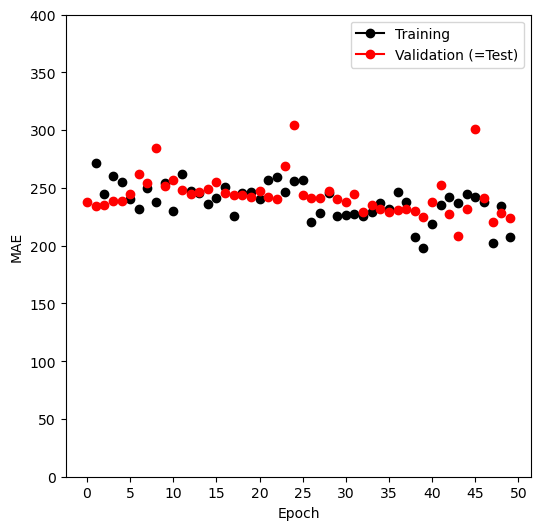

In [33]:
# 创建一个 1x1 的子图，图像大小为 6x6 英寸
fig, ax = subplots(1, 1, figsize=(6, 6))

# 绘制 MAE 随训练轮数变化的曲线，并设置 Y 轴标签和验证集标签
ax = summary_plot(hit_results,
                  ax,
                  col='mae',                # 绘制 MAE 指标
                  ylabel='MAE',             # 设置 Y 轴标签
                  valid_legend='Validation (=Test)')  # 设置验证集标签

# 设置 Y 轴范围为 0 到 400
ax.set_ylim([0, 400])

# 设置 X 轴刻度为 0 到 50 之间的 11 个整数
ax.set_xticks(np.linspace(0, 50, 11).astype(int));  


我们可以直接使用最终模型进行预测，并在测试数据上评估其性能。

在拟合之前，我们调用 hit_model 的 eval() 方法。这告诉 torch 将模型视为已经拟合完成，从而可以用于对新数据进行预测。对于我们的模型，最大的变化是 dropout 层将被关闭，即在对新数据进行预测时，不会随机丢弃权重。

In [34]:
# 设置模型为评估模式，禁用 dropout 层，以便在预测时使用完整的模型
hit_model.eval()

# 使用训练好的模型进行预测，X_test_t 是测试集特征数据
preds = hit_module(X_test_t)

# 计算预测值与真实值之间的绝对误差，并求平均值
# torch.abs() 计算绝对值，mean() 求平均
torch.abs(Y_test_t - preds).mean()


tensor(224.2696, grad_fn=<MeanBackward0>)

### Cleanup

In [35]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)


## Multilayer Network on the MNIST Digit Data
多层神经网络在 MNIST 数字数据集上的应用
torchvision 包提供了多个示例数据集，其中包括 MNIST 数字数据集。
第一步是获取训练集和测试集，torchvision.datasets 中的 MNIST() 函数便是为此提供的。

In [36]:
# 加载 MNIST 数据集，分为训练集和测试集
# root='data' 指定数据存储的目录，train=True 表示加载训练集，train=False 表示加载测试集
# download=True 表示如果数据不存在会自动下载
# transform=ToTensor() 将数据转换为 tensor 格式，便于后续使用
(mnist_train, 
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]

# 输出训练集数据（mnist_train）
mnist_train  # 这行代码显示训练集的基本信息（如样本数、类别等）


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

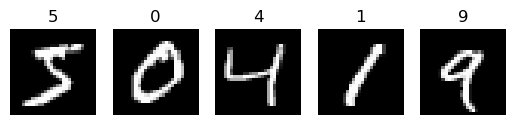

In [38]:
import matplotlib.pyplot as plt

# 显示前5张图片及其标签
for i in range(5):
    image, label = mnist_train[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray')  # squeeze() 去掉通道维度
    plt.title(str(label))
    plt.axis('off')

plt.show()


训练数据集中有 60,000 张图像，测试数据集中有 10,000 张图像。每张图像的大小为 $28 \times 28$，并以像素矩阵的形式存储。我们需要将每张图像转换成一个向量。

神经网络对输入数据的尺度比较敏感，就像岭回归和 Lasso 正则化对数据尺度的敏感性一样。在这里，输入数据是 8 位灰度值，范围从 0 到 255，因此我们需要将其归一化到单位区间 [0, 1]。{注意：8 位意味着 $2^8$，即 256。由于约定从 0 开始，因此可能的值范围是从 0 到 255。} 这个转换过程以及一些轴重排操作由 torchvision.transforms 包中的 ToTensor() 转换实现。

与我们在 Hitters 示例中做的类似，我们将训练集和测试集构建为数据模块，并将 20% 的训练图像留作验证集。

In [39]:
# 创建 MNIST 数据模块，分为训练集和测试集
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,        # 留出 20% 训练集数据作为验证集
                            num_workers=max_num_workers,  # 设置数据加载的最大工作进程数
                            batch_size=256)        # 每批次 256 张图像


让我们看一下将被输入到神经网络中的数据。我们遍历测试数据集的前几个批次，处理完两个批次后停止

In [40]:
# 遍历训练数据集的批次，查看每个批次的特征数据和标签数据的形状
for idx, (X_, Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)  # 输出当前批次的特征数据的形状
    print('Y: ', Y_.shape)  # 输出当前批次的标签数据的形状
    if idx >= 1:  # 处理完第一个批次后停止
        break


X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


我们看到每个批次的 X 包含 256 张大小为 1x28x28 的图像。这里的 1 表示单通道（灰度图像）。对于像 CIFAR100 这样的 RGB 图像，我们会看到图像的大小中 1 被替换为 3，表示三个 RGB 通道。

现在，我们准备好定义我们的神经网络。

In [41]:
# 定义 MNIST 模型类
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()  # 调用父类的构造函数
        # 第一个层，包含展平层、全连接层、ReLU 激活函数和 Dropout 层
        self.layer1 = nn.Sequential(
            nn.Flatten(),  # 展平输入数据，将 28x28 的图像转换为 1D 向量
            nn.Linear(28*28, 256),  # 全连接层，输入 28*28（784），输出 256
            nn.ReLU(),  # 激活函数 ReLU
            nn.Dropout(0.4))  # Dropout 层，防止过拟合，随机丢弃 40% 的神经元

        # 第二个层，包含全连接层、ReLU 激活函数和 Dropout 层
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),  # 全连接层，输入 256，输出 128
            nn.ReLU(),  # 激活函数 ReLU
            nn.Dropout(0.3))  # Dropout 层，随机丢弃 30% 的神经元

        # 定义最后的前向传播部分
        self._forward = nn.Sequential(
            self.layer1,  # 第一个层
            self.layer2,  # 第二个层
            nn.Linear(128, 10))  # 最后的全连接层，输出 10 类

    # 定义前向传播方法
    def forward(self, x):
        return self._forward(x)  # 返回前向传播的结果


我们看到在第一层中，每张 1x28x28 的图像首先被展平（flatten），然后映射到 256 个维度，并应用 ReLU 激活函数，同时进行 40% 的 Dropout 操作。

第二层将第一层的输出映射到 128 个维度，应用 ReLU 激活函数并进行 30% 的 Dropout 操作。

最后，将 128 个维度映射到 10 个维度，表示 MNIST 数据集中的 10 个类别。

In [42]:
mnist_model = MNISTModel()

我们可以检查模型是否能根据我们之前的批次 X_ 生成预期大小的输出

In [43]:
mnist_model(X_).size()

torch.Size([256, 10])

我们可以查看模型的摘要。不同于传递 input_size，我们可以直接传递一个形状正确的张量。在这种情况下，我们传递之前批处理的 X_。

In [44]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])  # 传递模型和输入数据，查看模型摘要，包括输入大小、输出大小和参数数量


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

设置模型和数据模块后，拟合模型
一旦设置好模型和数据模块，拟合这个模型与 Hitters 示例几乎是相同的。
与回归模型不同的是，这里我们将使用 SimpleModule.classification() 方法，该方法使用交叉熵损失函数，而不是均方误差损失函数。

In [45]:
mnist_module = SimpleModule.classification(mnist_model,  # 使用 SimpleModule 类的 classification 方法，设置为分类任务
                                           num_classes=10)  # 设置分类问题的类别数，这里是 10 类

mnist_logger = CSVLogger('logs', name='MNIST')  # 创建 CSVLogger 对象，用于记录训练过程中的日志数据


准备训练数据并拟合模型
现在，我们准备好进行训练了。最后一步是提供训练数据并拟合模型。我们禁用了进度条，以避免在浏览器中运行时出现冗长的输出。

In [46]:
mnist_trainer = Trainer(deterministic=True,  # 设置为确定性训练，确保每次训练的结果相同
                        max_epochs=30,  # 设置最大训练轮数为 30
                        logger=mnist_logger,  # 传入日志记录器，将训练过程中的日志存储到指定位置
                        enable_progress_bar=False,  # 禁用进度条，避免在浏览器中看到过长的输出
                        callbacks=[ErrorTracker()])  # 添加回调函数，计算并记录验证误差和测试误差

mnist_trainer.fit(mnist_module,  # 开始训练，传入分类模型
                  datamodule=mnist_dm)  # 传入数据模块，用于加载训练和验证数据


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=30` reached.


在这里，我们指定了 20% 的验证集拆分，因此训练实际上是在训练集的 60,000 个样本中的 80% 上进行的。这是另一种指定验证数据集的方式，类似于我们在 Hitters 数据中所做的操作。

SGD 使用 256 个样本的小批量来计算梯度，经过计算，我们得出一个 epoch 对应 188 次梯度更新步骤。

SimpleModule.classification() 包含默认的准确率指标
SimpleModule.classification() 默认包含了一个准确率指标。其他分类指标可以从 torchmetrics 中添加。我们将使用我们的 summary_plot() 函数来展示准确率随 epoch 变化的情况。

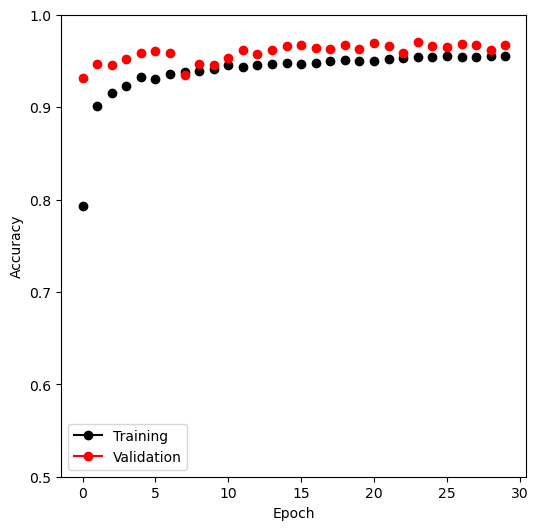

In [47]:
# 读取训练过程中记录的结果
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)

# 创建一个新的图形和坐标轴，设置图形大小为 6x6
fig, ax = subplots(1, 1, figsize=(6, 6))

# 使用 summary_plot 函数绘制训练和验证准确率随 epoch 变化的图
summary_plot(mnist_results,  # 使用训练过程中的结果数据
             ax,  # 传入坐标轴
             col='accuracy',  # 指定显示准确率
             ylabel='Accuracy')  # 设置 y 轴标签为准确率

# 设置 y 轴的范围为 0.5 到 1，因为准确率通常在这个区间内
ax.set_ylim([0.5, 1])

# 设置 y 轴的标签为 'Accuracy'
ax.set_ylabel('Accuracy')

# 设置 x 轴的刻度为 0 到 30，显示 7 个等间距的值
ax.set_xticks(np.linspace(0, 30, 7).astype(int))


再次使用 test() 方法评估准确率
我们再次使用 trainer 的 test() 方法来评估模型的准确率。该模型在测试数据上达到了 96% 的准确率。

In [48]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.967199981212616     │
│         test_loss         │    0.14888174831867218    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.14888174831867218, 'test_accuracy': 0.967199981212616}]

In [49]:
# 定义一个简单的线性分类器，用于 MNIST 数据集的分类任务
class MNIST_MLR(nn.Module):
    def __init__(self):
        # 初始化父类 nn.Module
        super(MNIST_MLR, self).__init__()
        
        # 定义一个顺序层，其中包含 Flatten 和 Linear 层
        # Flatten：将输入的 28x28 图像展平为一维向量（784个元素）
        # Linear：从784维的输入映射到10个类别（对应数字0-9）
        self.linear = nn.Sequential(
            nn.Flatten(),  # 将输入的28x28图像展平
            nn.Linear(784, 10)  # 从784维到10维（10个分类）
        )

    def forward(self, x):
        # 前向传播，通过线性层进行分类
        return self.linear(x)

# 创建模型实例
mlr_model = MNIST_MLR()

# 使用 SimpleModule.classification 来定义一个分类任务的模块
# 该模块用于训练和评估模型，并且会使用交叉熵损失
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)

# 创建一个 CSVLogger 用于日志记录，保存训练过程中的日志信息
mlr_logger = CSVLogger('logs', name='MNIST_MLR')


In [50]:
# 创建一个 Trainer 对象，用于训练模型
# 设置 deterministic=True 以确保每次训练结果相同（即使使用随机数），保证可复现性
# 设置 max_epochs=30 进行 30 个训练周期
# enable_progress_bar=False 禁用进度条显示，避免输出过长
# callbacks=[ErrorTracker()] 添加一个回调函数，追踪训练过程中的错误
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,  # 设置训练周期数
                      enable_progress_bar=False,  # 禁用进度条
                      callbacks=[ErrorTracker()])  # 添加错误追踪回调函数

# 训练模型，通过传入 mlr_module 和 mnist_dm 数据模块来启动训练
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)  # 开始训练


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
E:\fenglixuan\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNIST_MLR        | 7.9 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
--------------

In [51]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9240999817848206     │
│         test_loss         │    0.3186826705932617     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3186826705932617, 'test_accuracy': 0.9240999817848206}]

In [52]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

## IMDB Document Classification
对 IMDB 数据集实现情感分类模型

In [14]:
# 影评数据已经被预处理成了数字序列 —— 每个数字代表一个单词在词典中的编号
(imdb_seq_train, imdb_seq_test) = load_sequential(root='data/IMDB') 
# 加载顺序化的 IMDB 数据，限制每条影评最多保留 500 个词

padded_sample = np.asarray(imdb_seq_train.tensors[0][0]) 
# 取训练集中第一个样本的张量数据，并转换为 NumPy 数组（shape: [500]）

sample_review = padded_sample[padded_sample > 0][:12] 
# 去除填充（值为0的部分），只保留前12个非0单词索引

sample_review[:12]  
# 查看前12个有效的词索引，表示一段真实影评的词语编号


array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468])

数据集 imdb_seq_train 和 imdb_seq_test 都是 TensorDataset 类的实例。
用于构建它们的张量保存在其 tensors 属性中，其中第一个张量是特征 X，第二个是标签 Y。
我们取了特征的第一行并将其存储为 padded_sample。在对这些数据进行预处理时，如果序列长度不足，会在开头用 0 进行填充，因此我们通过仅保留 padded_sample > 0 的部分来去除这些填充。
随后，我们提供了该影评样本的前 12 个单词。

我们可以通过 ISLP.torch.imdb 模块中的 lookup 字典来查找这些单词的具体内容。

In [15]:
lookup = load_lookup(root='data/IMDB')  # 加载词汇索引表（字典），将整数索引映射回原始单词

' '.join(lookup[i] for i in sample_review)  # 将 sample_review 中的索引转换为单词，并用空格连接成一句完整的影评片段


"<START> this film was just brilliant casting location scenery story direction everyone's"

在我们的第一个模型中，我们为数据集中所有可能的 10,000 个单词分别创建了一个二元特征（binary feature）：

如果某个单词在某条影评中出现，该单词对应的特征位置就设为 1；

如果没有出现，则设为 0。

由于大多数影评都比较短（远远少于 10,000 个单词），因此这个特征矩阵中 超过 98% 的元素都是 0，也就是一个高度稀疏的矩阵。

这些数据可以通过 ISLP 库中的 load_tensor() 函数访问。

In [16]:
max_num_workers = 10  # 设置允许使用的最大线程数为 10（用于数据加载）

(imdb_train, imdb_test) = load_tensor(root='data/IMDB')  # 加载词袋形式的 IMDB 数据（稀疏张量），包括训练集和测试集

imdb_dm = SimpleDataModule(  # 创建一个数据模块（用于训练、验证和测试）
    imdb_train,              # 训练数据集（TensorDataset 类型，包含 X 和 Y）
    imdb_test,               # 测试数据集
    validation=2000,         # 从训练集中划分 2000 个样本作为验证集
    num_workers=min(6, max_num_workers),  # 设置用于数据加载的线程数，最多使用 6 个
    batch_size=512           # 设置批次大小为 512，加速训练过程
)


two-layer model 

In [17]:
class IMDBModel(nn.Module):  # 定义一个用于 IMDB 情感分类的神经网络模型
    def __init__(self, input_size):  # 构造函数，input_size 是输入特征维度（这里是 10000）
        super(IMDBModel, self).__init__()  # 初始化父类 nn.Module

        self.dense1 = nn.Linear(input_size, 16)  # 第一层：线性层，从 input_size 映射到 16 维
        self.activation = nn.ReLU()  # 使用 ReLU 激活函数
        self.dense2 = nn.Linear(16, 16)  # 第二层：全连接层，16 -> 16
        self.output = nn.Linear(16, 1)  # 输出层：将 16 维映射为一个标量（用于二分类）

    def forward(self, x):  # 定义前向传播逻辑
        val = x  # 输入赋值给 val
        for _map in [self.dense1,           # 第1层全连接
                     self.activation,       # ReLU
                     self.dense2,           # 第2层全连接
                     self.activation,       # ReLU
                     self.output]:          # 输出层
            val = _map(val)  # 顺序执行每个层
        return torch.flatten(val)  # 展平输出为一维向量（大小为 batch_size）



In [18]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1]) 
# 创建模型实例，输入大小为测试集中每条样本的特征维度（通常为10000）

summary(imdb_model,                                     # 使用 torchinfo.summary 打印模型结构信息
        input_size=imdb_test.tensors[0].size(),         # 指定输入张量的尺寸（batch_size, input_dim）
        col_names=['input_size',                        # 显示输入尺寸
                   'output_size',                       # 显示输出尺寸
                   'num_params'])                       # 显示每层参数个数



Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

模型概述

- **模型名称**: `IMDBModel`
- **输入形状**: `[25000, 10003]`，表示 **训练集中的 25000 条影评，每条影评包含 10003 个特征**（通常是词典大小）。
- **输出形状**: `[25000]`，表示每条影评对应一个预测结果，通常是情感分类的概率或标签。

各层详细解析

1. **线性层 (Linear) 1-1**
   - **输入形状**: `[25000, 10003]`，即每条影评包含 10003 个特征。
   - **输出形状**: `[25000, 16]`，该层将输入的 10003 个特征映射为 16 个特征。
   - **参数数量**: `160,064`
     - 计算方式：`10003 * 16 + 16 = 160,064`

2. **ReLU 激活层 (ReLU) 1-2**
   - **输入形状**: `[25000, 16]`，输出维度为 16。
   - **输出形状**: `[25000, 16]`，ReLU 激活函数后，输出维度保持不变。
   - **参数数量**: `--`，ReLU 层没有学习参数。

3. **线性层 (Linear) 1-3**
   - **输入形状**: `[25000, 16]`，即上一层的 16 个特征。
   - **输出形状**: `[25000, 16]`，该层输出 16 个特征。
   - **参数数量**: `272`
     - 计算方式：`16 * 16 + 16 = 272`

4. **ReLU 激活层 (ReLU) 1-4**
   - **输入形状**: `[25000, 16]`，输出维度为 16。
   - **输出形状**: `[25000, 16]`，ReLU 激活函数后，输出维度保持不变。
   - **参数数量**: `--`，ReLU 层没有学习参数。

5. **线性层 (Linear) 1-5**
   - **输入形状**: `[25000, 16]`，即上一层的 16 个特征。
   - **输出形状**: `[25000, 1]`，每个样本输出一个值（通常是情感分类的分数或标签）。
   - **参数数量**: `17`
     - 计算方式：`16 * 1 + 1 = 17`

---

模型总参数

- **总参数数量**: `160,353`
- **可训练参数数量**: `160,353`
- **不可训练参数数量**: `0`

模型中所有的参数都是可训练的。

---

我们将再次使用较小的学习率来训练这些数据，因此我们将一个 优化器（optimizer）传递给 SimpleModule。
由于影评被分类为 正面 或 负面 情感，因此我们使用 SimpleModule.binary_classification()。
{我们使用 binary_classification() 而不是 classification() 是因为 torchmetrics.Accuracy() 工作方式的微妙差异，以及目标数据类型的不同。}

In [19]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)  
# 使用 RMSprop 优化器，学习率为 0.001，优化 imdb_model 的参数

# 使用 SimpleModule 的 binary_classification 方法进行二分类任务，传入模型和优化器
imdb_module = SimpleModule.binary_classification(
    imdb_model,                # 传入模型（IMDBModel）
    optimizer=imdb_optimizer   # 使用之前定义的优化器
)

In [20]:
imdb_logger = CSVLogger('logs', name='IMDB')  # 创建一个 CSVLogger，用于记录训练日志，日志保存在 'logs' 目录下，命名为 'IMDB'

# 创建 Trainer 实例，用于训练模型
imdb_trainer = Trainer(
    deterministic=True,  # 设置为确定性训练（确保每次训练结果一致），即禁用所有的随机性
    max_epochs=30,       # 设置最大训练轮数为 30
    logger=imdb_logger,  # 将 CSVLogger 用于记录训练日志
    enable_progress_bar=False,  # 禁用进度条显示（适合不需要显示进度条的环境）
    callbacks=[ErrorTracker()]  # 添加回调函数 ErrorTracker，用于跟踪训练过程中的错误
)

# 使用 Trainer 进行模型训练
imdb_trainer.fit(imdb_module,            # 训练模型，传入先前定义的 imdb_module（包含模型和数据）
                 datamodule=imdb_dm)    # 传入数据模块 imdb_dm（管理数据加载和处理）


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | IMDBModel         | 160 K  | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
E:\fenglixuan\anaconda3\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` s

Evaluating the test error yields roughly 85% accuracy.

In [21]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)  # 使用训练器 imdb_trainer 在测试集上评估模型
test_results  # 输出测试结果


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8501200079917908     │
│         test_loss         │    1.0867838859558105     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0867838859558105, 'test_accuracy': 0.8501200079917908}]

In [24]:
(X_train, Y_train),  # 从加载的数据中获取训练集的特征（X_train）和标签（Y_train）
(X_valid, Y_valid),  # 获取验证集的特征（X_valid）和标签（Y_valid）
(X_test, Y_test) = load_sparse(  # 从 ISLP 中加载稀疏矩阵数据（用于 scikit-learn）
    validation=2000,  # 指定从训练数据中划分 2000 个样本作为验证集
    random_state=0,   # 设置随机种子，以保证数据划分的可重复性
    root='data/IMDB'  # 数据所在的文件夹路径
)



NameError: name 'X_train' is not defined

In [79]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()  # 计算 X_train 和标签 Y_train 的相关性，得到 lam_max，衡量特征的重要性

# 创建一组 lambda（正则化参数），其范围从 1 到 1e-4，通过对数均匀分布生成 50 个值
lam_val = lam_max * np.exp(np.linspace(np.log(1),   # 从 log(1) 开始
                                       np.log(1e-4),  # 到 log(1e-4) 结束
                                       50))           # 生成 50 个对数均匀分布的值


在使用 LogisticRegression() 时，正则化参数 $C$ 被指定为 $\lambda$ 的倒数。
Logistic 回归有多个求解器可供选择；这里我们使用的是 liblinear，它在稀疏输入格式下表现良好

In [80]:
logit = LogisticRegression(           # 创建逻辑回归模型实例
    penalty='l1',                      # 使用 L1 正则化（Lasso），有助于特征选择
    C=1/lam_max,                       # 设置正则化参数 C，C 是 λ 的倒数，lam_max 是从之前计算得出的最大相关性
    solver='liblinear',                # 使用 liblinear 求解器，适用于小规模数据集和稀疏数据
    warm_start=True,                   # warm_start=True 允许继续从上次训练中开始（适用于增量训练）
    fit_intercept=True                 # fit_intercept=True 表示模型会学习截距项（偏置）
)


In [81]:
coefs = []  # 用于存储每个正则化参数下的系数
intercepts = []  # 用于存储每个正则化参数下的截距项

# 对每个正则化参数值 lam_val 进行循环
for l in lam_val:
    logit.C = 1/l  # 设置正则化参数 C（C = 1 / lambda）
    logit.fit(X_train, Y_train)  # 用训练数据拟合模型
    coefs.append(logit.coef_.copy())  # 将当前模型的系数添加到 coefs 列表中
    intercepts.append(logit.intercept_)  # 将当前模型的截距项添加到 intercepts 列表中



np.squeeze() 函数是用来移除数组中所有维度为 1 的轴（即多余的维度）

In [82]:
coefs = np.squeeze(coefs)  # 去除 coefs 中的所有多余维度
intercepts = np.squeeze(intercepts)  # 去除 intercepts 中的所有多余维度


In [83]:
%%capture
# 创建一个 1x2 的子图，图像大小为 (16, 8)，y 轴共享
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)

# 对训练集、验证集、测试集进行循环，依次计算准确率
for ((X_, Y_), data_, color) in zip([(X_train, Y_train),
                                      (X_valid, Y_valid),
                                      (X_test, Y_test)],
                                     ['Training', 'Validation', 'Test'],
                                     ['black', 'red', 'blue']):
    
    # 计算线性预测值 (X * coef^T + intercept)，用于模型预测
    linpred_ = X_ * coefs.T + intercepts[None, :]
    
    # 通过比较线性预测值是否大于 0 来生成预测标签
    label_ = np.array(linpred_ > 0)
    
    # 计算每个预测标签的准确率
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    
    # 在第一个子图 axes[0] 上绘制 -log(lambda) 对应的准确率曲线
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',  # 点线样式
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)

# 添加图例
axes[0].legend()

# 设置 x 轴标签和 y 轴标签
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)



注意使用 %%capture，它可以抑制部分完成的图形的显示。当绘制复杂的图形时，这非常有用，因为步骤可以分布在两个或多个单元格中。现在，我们添加了一个 Lasso 准确率的图，并通过在单元格末尾输入图形的名称来显示组合后的图形。

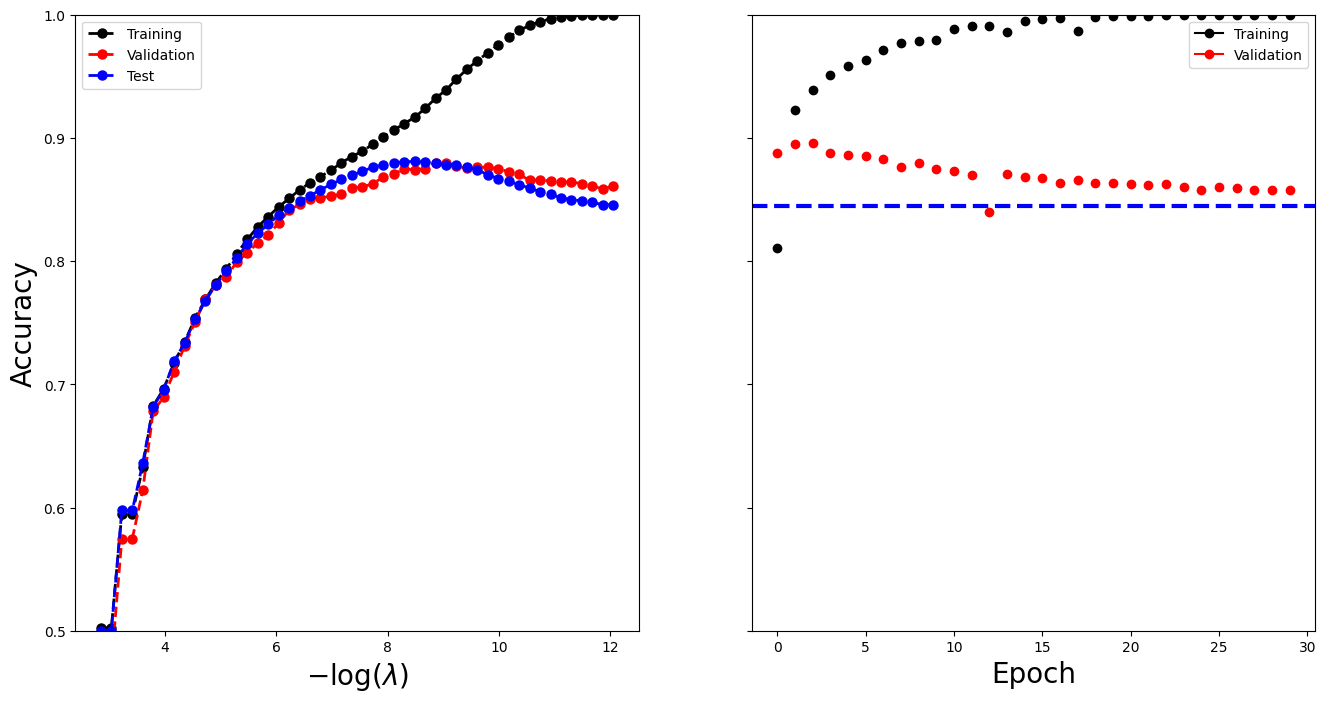

In [84]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)  # 读取记录在 imdb_logger 中的模型指标结果，返回一个 DataFrame

summary_plot(imdb_results,  # 使用 summary_plot 绘制图形
             axes[1],  # 绘制在第二个子图 axes[1] 上
             col='accuracy',  # 选择绘制准确率（'accuracy'）列
             ylabel='Accuracy')  # 设置 y 轴标签为 'Accuracy'

# 设置 x 轴刻度为从 0 到 30 的 7 个等距的整数值
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int)) 

# 设置 y 轴标签的字体大小
axes[1].set_ylabel('Accuracy', fontsize=20)

# 设置 x 轴标签的字体大小
axes[1].set_xlabel('Epoch', fontsize=20)

# 设置 y 轴的显示范围，准确率从 0.5 到 1 之间
axes[1].set_ylim([0.5, 1])

# 在图上绘制一条水平线，表示测试集的最终准确率
axes[1].axhline(test_results[0]['test_accuracy'],  # 使用从 test_results 中获取的测试集准确率
                color='blue',  # 设置线条颜色为蓝色
                linestyle='--',  # 设置线条为虚线
                linewidth=3)  # 设置线条宽度为 3

fig  # 显示图形


从图表中可以看到，Lasso 逻辑回归的准确率在大约 0.88 时达到峰值，神经网络的表现也是如此。

In [85]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)